# 教程2: Krusell-Smith模型

本教程将解决来自Auclert、Bardóczy、Rognlie、Straub (2021)论文中的Krusell-Smith模型:"使用序列空间雅可比矩阵求解和估计异质性代理人模型"([论文链接](https://www.bencebardoczy.com/publication/sequence-jacobian/sequence-jacobian.pdf))。

新概念:
- **HA模块**: 在微观和宏观层面表示异质性代理人
- **展开一般均衡雅可比矩阵**: 从逐步手动构建中获得见解
- **估计**: 从脉冲响应到似然函数

更多示例和SSJ工具包的信息,请访问我们的[GitHub页面](https://github.com/shade-econ/sequence-jacobian)。

In [157]:
! pip install sequence-jacobian


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\lenovo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [158]:
import copy
import numpy as np
import matplotlib.pyplot as plt

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules

## 1 模型描述
该模型可以在序列空间中表示为
$$
\textbf{F}_t(\textbf{X}, Z) \equiv 
\begin{pmatrix}
Y_t - Z_t K_{t-1}^\alpha L_t^{1-\alpha}
\\
r_t + \delta - \alpha Z_t \left(\frac{K_{t-1}}{L_t}\right)^{\alpha-1} 
\\
w_t - (1-\alpha) Z_t \left(\frac{K_{t-1}}{L_t}\right)^{\alpha}
\\
L_t - \sum_e \pi(e) e
\\
\mathcal{K}_t(\{r_s, w_s\}) - K_t
\end{pmatrix}
= \begin{pmatrix}  0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix},
\qquad t = 0, 1, \dots
$$

其中(总量)内生变量为 $\textbf{X} = (Y, K, L, r, w)$，唯一的外生变量是 $Z$。不失一般性，我们将 $\sum_e \pi(e) e = 1$ 标准化。

资本函数 $\mathcal{K}$ 来自于由贝尔曼方程表征的家庭部门
$$
\begin{align*}
V_t(e, k_{-}) = \max_{c, k} &\left\{\frac{c^{1-\sigma}}{1-\sigma} + \beta \mathbb{E}_t\left[V_{t+1}(e', k)|e \right] \right\}
\\
c + k &= (1 + r_t)k_{-} + w_t e 
\\
k &\geq 0
\end{align*}
$$

我们可以将这个模型表示为一个有向无环图(DAG)，只有一个未知数 $K$ 和一个目标，即资产市场出清。也就是说，我们可以将其写作
$$
H_t(K, Z) \equiv \mathcal{K}_t\left(\left\{\alpha Z_s K_{s-1}^{\alpha-1} - \delta, (1-\alpha) Z_s K_{s-1}^{\alpha}\right\}\right) - K_t = 0
$$

下面对该模型的原始问题和条件如何整合成
$$
F_t(\mathbf{X}, Z)=0
$$
做以说明。

---

### 模型原始问题

模型主要描述一个含有异质性家庭和企业部门的动态一般均衡问题。总体要解决的问题可以概括为：**在给定技术冲击 $Z_t$ 和历史资本 $K_{t-1}$ 的条件下，求解一组宏观变量 $\mathbf{X}_t = (Y_t, K_t, L_t, r_t, w_t)$，使得生产、要素定价、劳动市场和资本市场均衡条件同时成立。**

具体来说：

1. **企业部门与生产**  
   - **生产函数**：企业利用资本和劳动生产，总产出由生产函数给出，
     $$
     Y_t = Z_t\, K_{t-1}^{\alpha}\, L_t^{1-\alpha}\,.
     $$
   - **边际产品决定要素价格**：根据一阶条件，资本和劳动的价格分别满足
     $$
     r_t + \delta = \alpha Z_t \left(\frac{K_{t-1}}{L_t}\right)^{\alpha-1}, \quad
     w_t = (1-\alpha) Z_t \left(\frac{K_{t-1}}{L_t}\right)^{\alpha}\,.
     $$
     其中 $\delta$ 为折旧率。

2. **家庭部门与资本供给**  
   - **家庭最优化问题**：每个家庭的决策由以下贝尔曼方程描述，
     $$
     V_t(e,k_{-}) = \max_{c,k} \left\{\frac{c^{1-\sigma}}{1-\sigma}+\beta\,\mathbb{E}_t\left[V_{t+1}(e',k)\right]\right\}\,,
     $$
     受到预算约束
     $$
     c + k = (1+r_t)k_{-} + w_t\, e \quad \text{以及} \quad k\geq 0\,.
     $$
   - 由家庭部门求解的最优储蓄行为可以归纳为一个**资本供给函数** $\mathcal{K}_t(\{r_s,w_s\})$：给定未来的利率和工资路径，家庭部门会选择相应的储蓄（或资产）水平。这一函数代表着整个家庭群体的决策结果。

3. **市场出清条件**  
   - **劳动市场**：劳动供给 $L_t$ 与家庭异质性下按权重 $\pi(e)$ 加权的各个劳动“状态”匹配（通常标准化，使得 $\sum_e \pi(e)e = 1$）。
   - **资本市场**：由家庭部门决策得到的资本供给 $\mathcal{K}_t(\{r_s,w_s\})$ 必须与生产部门所使用的资本 $K_t$ 相等。

---

### 如何组成 $F_t(\mathbf{X}, Z)=0$

将上述各个方面的条件写成零等式，模型用一个向量方程表达，即：

1. **生产方程**  
   $$
   Y_t - Z_t K_{t-1}^{\alpha} L_t^{1-\alpha}=0\,.
   $$

2. **利率定价条件**  
   $$
   r_t + \delta - \alpha Z_t \left(\frac{K_{t-1}}{L_t}\right)^{\alpha-1}=0\,.
   $$

3. **工资定价条件**  
   $$
   w_t - (1-\alpha) Z_t \left(\frac{K_{t-1}}{L_t}\right)^{\alpha}=0\,.
   $$

4. **劳动市场清算条件**  
   $$
   L_t - \sum_e \pi(e)e = 0\,.
   $$
   （这里通常通过将 $\sum_e \pi(e)e$ 标准化为1来表达市场均衡。）

5. **资本市场出清（资产市场）条件**  
   $$
   \mathcal{K}_t\big(\{r_s,w_s\}\big) - K_t = 0\,.
   $$
   其中，$\mathcal{K}_t\big(\{r_s,w_s\}\big)$ 表示家庭部门在给定利率和工资路径下，经过贝尔曼方程最优化后决定的资本存量。

把上面这五个式子组合在一起，即得
$$
\mathbf{F}_t(\mathbf{X}, Z) \equiv 
\begin{pmatrix}
Y_t - Z_t\, K_{t-1}^{\alpha} L_t^{1-\alpha} \\
r_t + \delta - \alpha Z_t\left(\frac{K_{t-1}}{L_t}\right)^{\alpha-1} \\
w_t - (1-\alpha) Z_t \left(\frac{K_{t-1}}{L_t}\right)^{\alpha} \\
L_t - \sum_e \pi(e)e \\
\mathcal{K}_t\big(\{r_s,w_s\}\big)-K_t
\end{pmatrix}
= \begin{pmatrix}0\\0\\0\\0\\0\end{pmatrix}\,.
$$

这种表示方式的含义如下：

- **第一项**保证生产函数成立，即输出正好由 TFP、资本和劳动共同决定；
- **第二项和第三项**确保企业部门由最优条件导出的利率和工资与实际给定的 $r_t$ 和 $w_t$ 匹配；
- **第四项**为劳动市场均衡；
- **第五项**则要求经过家庭部门最优化后决定的资本供给正好等于企业部门在当期使用的资本，从而实现资产市场出清。

因此，模型的整体目标是寻找一个序列 $\{\mathbf{X}_t\}$（及敏感于外生冲击 $Z_t$ 的路径），使得上述所有均衡条件同时成立，即满足 $\mathbf{F}_t(\mathbf{X}, Z)=0$。

---

这种方式将微观家庭部门的决策（通过$\mathcal{K}_t$表示）与企业部门的生产、要素定价以及市场清算条件整合在一起，从而构成了完整的动态一般均衡系统。


## 2 设置异质性主体模块

求解异质性主体(HA)问题包含3个不同的步骤。
1. **向后迭代**: 求解个体政策函数
2. **向前迭代**: 求解分布
3. **聚合**: 获得宏观结果
   
向后迭代是模型特定的，需要仔细考虑。向前迭代相对机械，它只依赖于状态变量的数量和类型(离散或连续)。聚合是完全机械的。因此，我们只要求用户提供向后迭代的方法。向前迭代和聚合会自动处理。

所以，主要任务是编写一个代表贝尔曼方程的**向后步进函数**。这必须是迭代求解方法(如在网格上求解最优策略的值函数迭代)的单个步骤。对于我们这里处理的标准收入波动问题，[Carroll (2006)](https://www.sciencedirect.com/science/article/pii/S0165176505003368)的内生网格点方法(EGM)是最佳实践。
- 形式上，我们需要编写一个函数，将"向后变量"明天的期望值映射到今天相同网格上的"向后变量"。在EGM中，向后变量是值函数对资产的偏导数，因此向后步进函数是 $f: \mathbb{E}\left[\partial_k V(e', k)\right|e] \to \partial_k V(e, k_{-}).$

一旦我们有了向后步进函数，我们就可以使用装饰器`@het`将其转换为HetBlock的实例。我们只需要指定：
- `exogenous`: 离散外生状态的转移矩阵的名称(一个或多个，按前向顺序)
- `policy`: 对应于连续内生状态的政策名称(一个或两个)
- `backward`: 我们正在迭代的向后变量的名称(这里是值函数对资产的一阶导数`Va`)
- `backward_init`: 一个初始化向后变量猜测的函数

In [159]:
def household_init(a_grid, e_grid, r, w, eis):
    """
    Initialize the marginal value of assets (Va) for households.

    This function computes an initial guess for the marginal utility derivative of 
    the value function using a simple consumption guess. The cash-on-hand (coh) 
    is computed based on asset returns and labor income. Then, it assumes a proportional 
    consumption (10% of coh) to derive the marginal utility, adjusting for the interest rate.

    Parameters:
    a_grid : numpy.ndarray
        Asset grid (1-D array) representing different levels of assets.
    e_grid : numpy.ndarray
        Productivity grid (1-D array) representing different productivity levels.
    r : float
        The ex-post real interest rate.
    w : float
        The wage rate.
    eis : float
        Elasticity of intertemporal substitution.

    Returns:
    numpy.ndarray
        An array representing the initial marginal value of assets (Va) for each combination
        of productivity and asset level.
    """
    # Compute cash-on-hand (coh) as the sum of returns on assets and labor income.
    # np.newaxis is used to correctly broadcast the addition over all combinations of a_grid and e_grid.
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
    
    # Set an initial consumption guess as 10% of cash-on-hand.
    # Compute the marginal utility based on this guess with CRRA utility.
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)
    
    return Va

@het(exogenous='Pi', policy='a', backward='Va', backward_init=household_init)
def household(Va_p, a_grid, e_grid, r, w, beta, eis):
    """
    Perform a single backward iteration for the household's dynamic programming problem 
    using the endogenous gridpoint method (EGM) with CRRA utility.

    This function computes the updated marginal value of assets (Va), optimal asset policy (a), 
    and consumption policy (c) for households today given the expected marginal utility of assets 
    next period (Va_p). The approach follows the EGM methodology as per Carroll (2006) and uses 
    the envelope condition under CRRA utility.

    Parameters
    ----------
    Va_p : numpy.ndarray
        (nE, nA) array of expected marginal utility of assets for the next period.
    a_grid : numpy.ndarray
        (nA,) asset grid representing different levels of assets.
    e_grid : numpy.ndarray
        (nE,) productivity grid representing different labor productivity levels.
    r : float
        Ex-post real interest rate.
    w : float
        Wage rate.
    beta : float
        Discount factor.
    eis : float
        Elasticity of intertemporal substitution. Note: The CRRA risk aversion coefficient is 1/eis.

    Returns
    -------
    Va : numpy.ndarray
        (nE, nA) updated marginal value of assets today.
    a : numpy.ndarray
        (nE, nA) asset policy (optimal asset choices) for households today.
    c : numpy.ndarray
        (nE, nA) consumption policy for households today.
    
    Notes
    -----
    The computation follows these steps:
      1. Adjust the expected marginal utility next period by the discount factor to obtain uc_nextgrid.
      2. Invert the marginal utility function to derive next period consumption (c_nextgrid).
      3. Compute cash-on-hand (coh) by adding the asset returns and labor income.
      4. Interpolate using the endogenous gridpoint method to obtain the asset policy 'a'.
      5. Ensure that the asset policy does not fall below the minimum asset level.
      6. Compute consumption (c) as the difference between cash-on-hand and the chosen asset.
      7. Update the current marginal value function (Va) via the envelope condition.
    """
    # Step 1: Compute the discounted expected marginal utility for next period.
    uc_nextgrid = beta * Va_p  # Multiply expected marginal utility by beta.

    # Step 2: Invert the marginal utility function to find next period consumption.
    # For CRRA utility, u'(c) = c^(-1/eis), hence c_nextgrid = (u')^(-eis).
    c_nextgrid = uc_nextgrid ** (-eis)

    # Step 3: Calculate cash-on-hand (coh).
    # Cash-on-hand is given by asset returns plus labor income.
    # a_grid is reshaped with np.newaxis to allow broadcasting with e_grid.
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]

    # Step 4: Compute the optimal asset policy using the EGM interpolation.
    # The interpolate_y method inverts the consumption function by mapping (consumption + assets)
    # onto the corresponding asset level in the cash-on-hand grid.
    a = interpolate.interpolate_y(c_nextgrid + a_grid[np.newaxis, :], coh, a_grid)

    # Step 5: Ensure the asset policy doesn't fall below the minimum asset value.
    misc.setmin(a, a_grid[0])

    # Step 6: Determine the consumption policy as the residual of cash-on-hand after choosing 'a'.
    c = coh - a

    # Step 7: Update the marginal value of assets (Va) today using the envelope condition.
    # Under CRRA utility, u'(c) = c^(-1/eis), so Va = (1 + r) * u'(c).
    Va = (1 + r) * c ** (-1 / eis)

    return Va, a, c

下面解释这段代码的含义以及它所依据的数学公式。

该代码用于为家庭部门的贝尔曼方程求解过程中的**向后迭代**步骤提供一个初始猜测，具体来说，是初始化“资产边际价值” $ \text{Va} $（也可以看作是值函数对资产的偏导数）。这一初始化在采用内生网格点方法（EGM）时十分重要，因为后续的迭代过程需要一个初始的边际值函数来得到家庭的最优消费和储蓄政策。

代码的主要计算过程可以分为两步：

1. **计算现金持有量（cash-on-hand）**

   根据家庭的预算约束，家庭在期初的可支配资源（现金持有量）由资产收益和劳动收入构成：
   $$
   \text{coh} = (1 + r)a + we\,.
   $$
   这里：
   - $ a $ 表示资产（在代码中为资产网格 `a_grid`）；
   - $ r $ 为实际利率；
   - $ w $ 为工资率；
   - $ e $ 为劳动生产率（生产率网格 `e_grid`）。

   代码通过使用 `np.newaxis` 将两个一维数组扩展成二维形式，从而对每种 $ e $ 与每个 $ a $ 都能完成正确的广播相加。

2. **利用消费初始猜测估计边际效用**

   家庭优化中常采用 CRRA（常数相对风险厌恶）效用函数，其形式为：
   $$
   u(c) = \frac{c^{1-\gamma}}{1-\gamma}\quad (\gamma \neq 1)
   $$
   对应的边际效用为
   $$
   u'(c) = c^{-\gamma}\,.
   $$
   在这里，我们将风险厌恶系数设定为 $\gamma = \frac{1}{\text{eis}}$，因此有
   $$
   u'(c) = c^{-1/\text{eis}}\,.
   $$

   又利用 Envelope 定理：在最优条件下，家庭在资产上的边际价值应满足
   $$
   V'(a) = (1+r) \, u'(c)\,.
   $$
   
   为了得到一个初步估计，代码假定家庭在决策时仅消费现金持有量的一小部分（这里取 10%），即消费初始猜测为
   $$
   c = 0.1 \times \text{coh}\,.
   $$
   于是初始猜测的边际价值便为
   $$
   V'(a) \approx (1+r) \times (0.1\,\text{coh})^{-1/\text{eis}}\,.
   $$

总结起来，代码中：

```python
coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
Va = (1 + r) * (0.1 * coh) ** (-1 / eis)
```

就是按照上述预算约束和边际效用定义计算出每个 $(e,a)$ 组合下初始资产边际价值 $ V'(a) $ 的猜测值。

这种初始猜测将作为后续向后迭代中动态规划求解的起点，从而帮助求解家庭最优的储蓄（资产决策）和消费政策。


下面给出这段代码所做工作的详细说明，以及它背后的数学公式依据。

---

### 代码的总体目的

该函数实现了家庭部门在动态规划中“向后”一步的迭代，采用的是内生网格点方法（EGM）。在家庭的贝尔曼方程中，关键在于根据下一期边际价值函数（Va\_p）得到当前期的最优消费政策和储蓄（或资产）政策。本函数依托CRRA效用函数（其中风险厌恶系数取 $ \gamma = 1/\text{eis} $）以及Envelope条件来更新当前期的资产边际价值 $ \text{Va} $（即值函数关于资产的导数）。

---

### 代码中的主要计算步骤和数学依据

1. **折现调整得到下一期边际效用**

   ```python
   uc_nextgrid = beta * Va_p
   ```
   
   在贝尔曼方程中，未来的边际效用会乘以折现因子 $\beta$。这里，$ \text{Va\_p} $ 表示下一期在各个状态下的边际价值，通过乘以 $\beta$，得到折现后的预期边际效用。

2. **从边际效用反演得到下一期消费猜测**

   ```python
   c_nextgrid = uc_nextgrid ** (-eis)
   ```
   
   在CRRA效用下，
   $$
   u'(c) = c^{-1/\text{eis}}\,.
   $$
   反过来，由 $ u'(c) $ 求消费，则有
   $$
   c = \left(u'(c)\right)^{-\text{eis}}\,.
   $$
   因此，此处将折现后的边际效用取 $-\text{eis}$ 次幂，得到下一期的消费水平。

3. **计算现金持有量（cash-on-hand, coh）**

   ```python
   coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
   ```
   
   现金持有量由两个部分构成：
   - **资产收益**：之前的资产经过利率变动，即 $(1+r) \, a$。
   - **劳动收入**：工资收入 $w \times e$。
   
   由于资产网格和生产率网格分别为一维数组，为了对所有可能的组合进行计算，使用了 `np.newaxis` 将二者扩展为二维形式。

4. **利用EGM方法通过插值获得最优资产政策**

   ```python
   a = interpolate.interpolate_y(c_nextgrid + a_grid, coh, a_grid)
   ```
   
   EGM方法的核心在于“反向”求解家庭的最优决策。这里利用了“内生网格点法”的插值思想：假设已知未来的消费水平 $ c_{\text{next}} $ 和初始资产水平 $ a $，那么对应的”内生现金持有量“为 $ c_{\text{next}} + a $。利用这个累计值与当前期现金持有量 $ coh $ 建立一一对应关系，通过插值计算出当前最优资产政策。这一步确保：家庭选择的资产水平恰好使得从当前现金持有量中剔除选择后的储蓄后，剩余资金用于消费可以满足最优条件。

5. **确保资产政策不低于最小值**

   ```python
   misc.setmin(a, a_grid[0])
   ```
   
   为防止插值可能导致得到低于允许下界的资产水准，调用辅助函数保证资产选择不低于最小资产（通常为资产网格的第一个元素）。

6. **计算当前期消费水平**

   ```python
   c = coh - a
   ```
   
   一旦得到了最优储蓄（资产政策） $ a $，可通过预算约束求得当前期消费：
   $$
   c = \text{coh} - a\,.
   $$

7. **利用Envelope条件更新当前期边际价值**

   ```python
   Va = (1 + r) * c ** (-1 / eis)
   ```
   
   根据Envelope条件，当前期的资产边际价值应满足：
   $$
   V'(a) = (1+r) \, u'(c)\,.
   $$
   因为CRRA效用下 $ u'(c) = c^{-1/\text{eis}} $，故更新公式为：
   $$
   Va = (1+r) \, c^{-1/\text{eis}}\,.
   $$

---

### 装饰器@het的作用

函数前的装饰器：
```python
@het(exogenous='Pi', policy='a', backward='Va', backward_init=household_init)
```
说明此函数是一个异质性主体模块的一部分。装饰器会自动将该向后迭代函数包装为HetBlock实例，告知系统：
- 用于离散外生状态的转移矩阵名称为 `Pi`；
- 对应的资产政策名称为 `a`；
- 迭代的向后变量为 `Va`；
- 初始猜测函数为前面定义的 `household_init`。

这使得在整个模型的求解过程中，下行（向后）和上行（向前）迭代、以及聚合步骤能够自动协同工作。

---

### 总结

整个函数按照EGM方法一步步完成更新过程：

1. 折现预期边际效用；
2. 利用CRRA反演得到下一期消费；
3. 计算现金持有量；
4. 通过插值方法获得最优资产政策；
5. 计算当前期消费；
6. 依据Envelope条件更新边际价值。

这些步骤均有明确的数学公式作为理论依据，并整合家庭部门的贝尔曼最优化问题。函数返回的是更新后的当前期边际价值 $ Va $、最优资产选择 $ a $ 以及消费政策 $ c $。


回想一下,每个区块(包括HA区块)都代表序列空间中的一个函数。HA区块的特殊之处在于它们既有宏观输出(总量)也有微观输出(分布、政策函数)。

In [160]:
print(household)
print(f'Inputs: {household.inputs}')
print(f'Macro outputs: {household.outputs}')
print(f'Micro outputs: {household.internals}')

<HetBlock 'household'>
Inputs: ['a_grid', 'e_grid', 'r', 'w', 'beta', 'eis', 'Pi']
Macro outputs: ['A', 'C']
Micro outputs: ['D', 'Dbeg', 'Pi', 'Va', 'a', 'c']


`household`区块的输入包括标量(`w`、`r`、`eis`、`beta`)和数组(`a_grid`、`e_grid`、`Pi`)。SSJ方法的一个关键假设是区块之间只通过标量(标量序列)连接。这确保了所有区块都有兼容的雅可比矩阵,可以沿着有向无环图(DAG)累积。多维输入应该被视为特定HetBlock的**内部**变量。

这个约定通过`hetinput`和`hetoutput`函数得以实现。这些是我们可以附加到HetBlock的常规Python函数。hetinputs的目的是将标量(来自区块外部)映射到区块需要的多维输入。hetoutputs的目的是将区块的多维输出(例如`a`、`c`)映射到感兴趣的新的多维输出。可以这样理解。HetBlock的评估分3个步骤:
1. 评估hetinputs;获得多维输入
2. 评估核心区块(向后迭代);获得政策函数
3. 评估hetoutputs;获得其他感兴趣的输出

一个HetBlock可以有零个或多个`hetinputs`和`hetoutputs`。此外,hetinputs之间允许以非循环方式相互依赖。hetoutputs也是如此。

继续我们的示例,让我们添加一个创建网格的hetinput函数。注意`household_ext`不再有多维输入了。它通过调用`make_grid`在内部知道如何创建这些输入。

In [161]:
def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    """
    Create the grids for the income process and assets for the household model.

    Parameters:
        rho_e (float): Persistence parameter for the income process.
        sd_e (float): Standard deviation of the income shock.
        nE (int): Number of discrete income states.
        amin (float): Minimum asset value.
        amax (float): Maximum asset value.
        nA (int): Number of asset grid points.

    Returns:
        tuple: A tuple containing:
            - e_grid: Grid representing income states.
            - Pi: Transition probability matrix for the income process.
            - a_grid: Discretized asset grid.
    """
    # Generate the income grid and transition matrix using the Rouwenhorst method.
    e_grid, _, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    
    # Generate the asset grid based on the provided minimum, maximum, and number of points.
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    
    return e_grid, Pi, a_grid


# Extend the household block by adding the make_grid function as a heterogeneous input.
household_ext = household.add_hetinputs([make_grid])

# Print the extended household block and its inputs for verification.
print(household_ext)
print(f'Inputs: {household_ext.inputs}')

<HetBlock 'household' with hetinput 'make_grid'>
Inputs: ['r', 'w', 'beta', 'eis', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA']


- 上面的household区块是我们在工具包中包含的通用"标准不完全市场模型"的一个特例，该模型位于`sequence_jacobian/examples/hetblocks/household_sim.py`中。
- 构成Krusell-Smith模型的其余区块列在下面，也可以在`sequence_jacobian/examples/krusell_smith.py`中找到。

In [162]:
@simple
def firm(K, L, Z, alpha, delta):
    """
    Compute factor returns and output using a Cobb-Douglas production function.

    Parameters:
        K: A callable or value representing capital. When called as K(-1), it returns the lagged capital value.
        L (float): Labor input.
        Z (float): Total factor productivity.
        alpha (float): Capital share parameter.
        delta (float): Depreciation rate of capital.

    Returns:
        tuple: A tuple (r, w, Y) where:
            r (float): Net interest rate (marginal product of capital minus depreciation).
            w (float): Wage rate (marginal product of labor).
            Y (float): Total output.
    """
    # Compute net interest rate: marginal product of capital minus depreciation.
    r = alpha * Z * (K(-1) / L) ** (alpha - 1) - delta

    # Compute wage rate: marginal product of labor.
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha

    # Compute total output using the Cobb-Douglas production function.
    Y = Z * (K(-1) ** alpha) * (L ** (1 - alpha))

    return r, w, Y


@simple
def mkt_clearing(K, A, Y, C, delta):
    """
    Evaluate market clearing conditions in the asset and goods markets.

    Parameters:
        K (float): Aggregate capital.
        A (float): Total assets in the economy.
        Y (float): Total output.
        C (float): Total consumption.
        delta (float): Depreciation rate of capital.

    Returns:
        tuple: A tuple (asset_mkt, goods_mkt) where:
            asset_mkt (float): Excess demand in the asset market (assets minus capital).
            goods_mkt (float): Excess demand in the goods market (output minus consumption and capital depreciation).
    """
    # Calculate asset market imbalance: total assets minus aggregate capital.
    asset_mkt = A - K

    # Calculate goods market imbalance: total output minus consumption and depreciation spending.
    goods_mkt = Y - C - delta * K

    return asset_mkt, goods_mkt

Let's put the model together.

In [163]:
ks = create_model([household_ext, firm, mkt_clearing], name="Krusell-Smith")
print(ks.inputs)

['beta', 'eis', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'K', 'L', 'Z', 'alpha', 'delta']


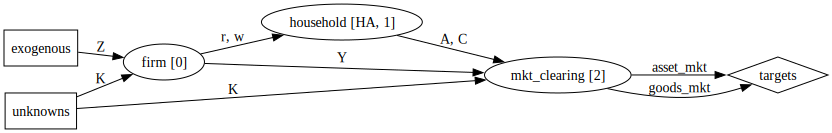

In [164]:
from sequence_jacobian import drawdag

inputs = ['Z']
unknowns = ['K']  
targets = ['asset_mkt', 'goods_mkt']

drawdag(ks, exogenous=inputs, unknowns=unknowns, targets=targets,leftright= True)

## 3 校准稳态
接下来，我们在一般均衡下校准模型。校准过程实质上是在所有其他外生参数给定的条件下，找到合适的贴现因子 $\beta$ 以达到目标利率。我们使用来自 `scipy.optimize` 包的Brent方法(一种在区间上求解根的高效方法)来实现这一目标。

虽然这里还有可能获得额外的效率提升(例如，在过程中更新我们的政策和分布的初始猜测)，但由于这些不是我们的重点，所以我们不会实现它们。

我们的默认值与标准的Krusell-Smith校准略有不同，主要是假设了7状态的收入过程和较低的资本份额。更多的风险增加了预防性储蓄动机，而较少的资本限制了自我保险的能力。这些变化导致了更高的边际消费倾向(MPC)和更少的代表性代理人(RA)类似行为。

In [165]:
calibration = {'eis': 1, 'delta': 0.025, 'alpha': 0.11, 'rho_e': 0.966, 'sd_e': 0.5, 'L': 1.0,
               'nE': 3, 'nA': 100, 'amin': 0, 'amax': 200}
unknowns_ss = {'beta': 0.98, 'Z': 0.85, 'K': 3.}
targets_ss = {'r': 0.01, 'Y': 1., 'asset_mkt': 0.}

ss = ks.solve_steady_state(calibration, unknowns_ss, targets_ss, solver='hybr')

print(ss)

<SteadyStateDict: ['eis', 'delta', 'alpha', 'rho_e', 'sd_e', 'L', 'nE', 'nA', 'amin', 'amax', 'beta', 'Z', 'K', 'r', 'w', 'Y', 'A', 'C', 'asset_mkt', 'goods_mkt'], internals=['household']>


让我们检查稳态。
- `solve_steady_state` 方法返回了一个 `SteadyStateDict` 对象。
- `ss` 在两个层级存储变量: *top* 和 *internal*
- top 层包含标量，可以被模型的所有模块访问
- internal 层包含模块特定的多维变量



Let's plot the consumption policy function for all skill types  as a function of assets.

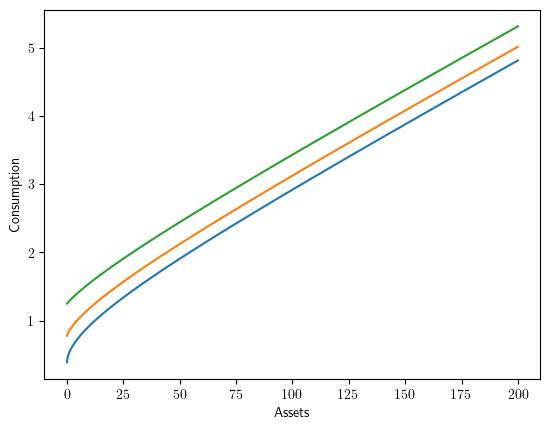

In [166]:
plt.plot(ss.internals['household']['a_grid'], ss.internals['household']['c'].T)
plt.xlabel('Assets'), plt.ylabel('Consumption')
plt.show()

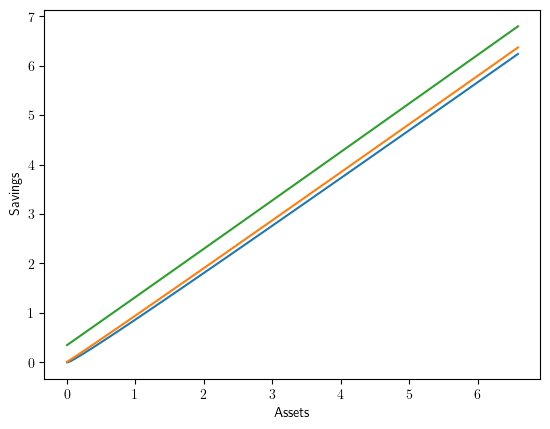

In [167]:
plt.plot(ss.internals['household']['a_grid'][:50],ss.internals['household']['a'].T[:50])
plt.xlabel('Assets')
plt.ylabel('Savings')
plt.show()

### 稳态求解的速度
我们的向后和向前迭代使用了Numba，这是一个[即时编译库](https://numba.pydata.org/numba-doc/dev/user/5minguide.html)，可以将纯数值Python代码转换为快速的机器代码。第一次运行函数时会有一些编译延迟，这类似于C++、Fortran和Julia等语言的编译时间(但耗时要少得多)。

现在我们已经运行了一遍所有内容，可以对稳态校准程序计时了。虽然高效的稳态求解并不是本笔记本或我们方法的重点，但看到性能仍然相当不错还是令人欣慰的：

In [168]:
%time ss = ks.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

CPU times: total: 172 ms
Wall time: 173 ms


事实上,这个简单的例子计算速度如此之快,以至于将资产网格点的数量从500增加到2000(因此状态总数从$7 \times 500=3500$增加到$7 \times 2000 = 14000$)也只使计算时间增加不到4倍。

In [169]:
calibration_highA = {**calibration, **{"nA": 2000}}

%time _ = ks.solve_steady_state(calibration_highA, unknowns_ss, targets_ss, solver="hybr")

CPU times: total: 484 ms
Wall time: 505 ms


## 4 雅可比矩阵
雅可比矩阵是在序列空间中求解和估计模型的关键概念。每个模型模块都有自己的雅可比矩阵，这些矩阵可以通过链式法则组合成完整模型的雅可比矩阵。在 $T$ 维(截断)序列空间中的雅可比矩阵是一个 $T \times T$ 矩阵,形式如下:

$$
\frac{d Y}{d X} = 
\begin{pmatrix}
\frac{d Y_0}{d X_0} & \frac{d Y_0}{d X_1} & \dots & \frac{d Y_0}{d X_{T-1}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{d Y_{T-1}}{d X_0} & \frac{d Y_{T-1}}{d X_1} & \dots & \frac{d Y_{T-1}}{d X_{T-1}}
\end{pmatrix}
$$

该矩阵在稳态处求值。每一列都可以解释为对一期新闻冲击的脉冲响应。

### 4.1 简单模块
为了建立直观认识，让我们从上面实例化的企业模块开始。在我们的代码中，简单模块被指定为带有``@simple``装饰器的常规Python函数。在函数体中，我们直接实现相应的均衡条件。该装饰器将函数转换为``SimpleBlock``类的实例，该类除其他功能外，还知道如何处理时间位移，例如使用`K(-1)`表示1期滞后和`r(+1)`表示1期超前。一般来说，可以写成(-s)和(+s)来表示s期的滞后和超前。

模块可以通过`jacobian`方法计算其雅可比矩阵。该方法接收由`solve_steady_state`方法返回的`SteadyStateDict`对象，以及两个可选输入:截断视界和需要求导的变量列表。它以嵌套字典的形式返回雅可比矩阵，其中第一层是输出变量$Y$，第二层是输入变量$X$。

In [170]:
J_firm = firm.jacobian(ss, inputs=['K', 'Z','L'])

print(J_firm)

<JacobianDict outputs=['r', 'w', 'Y'], inputs=['K', 'Z', 'L']>


默认情况下，`jacobian`会计算每个输入-输出对的雅可比矩阵。在实践中，只对内生变量和冲击求导是有意义的，因此需要使用`inputs`选项。在这个模型中，资本和全要素生产率是唯一会发生变化的输入。

雅可比矩阵是对角的，因为生产函数不依赖于生产率的超前或滞后项。这种稀疏性在简单模块中很常见，我们编写SimpleBlock类时充分利用了这一点。例如，如果我们不指定截断参数$T$(这是推荐的做法)，`jacobian`会返回雅可比矩阵的一个更高效的稀疏表示。

In [171]:
print(J_firm['Y']['Z'].matrix(3))
print('\n')
print(J_firm['Y']['Z'])

[[1.13424196 0.         0.        ]
 [0.         1.13424196 0.        ]
 [0.         0.         1.13424196]]


SimpleSparse({(0, 0): 1.134})


The output means that the only non-zero element is 1.134 along the main diagonal.

### 4.2 异质性代理模块
异质性代理模块具有更复杂的雅可比矩阵，但它们具有规律的结构，我们可以利用这一点来快速计算。关于我们的**虚假新闻算法**的全面介绍，请参阅论文。

`HetBlock`对象有一个`jacobian`方法，类似于上面`SimpleBlock`对象的方法。

In [172]:
J_ha = household.jacobian(ss, inputs=['r', 'w'], T=5)
print(J_ha['C']['r'])

[[ 0.09542192 -0.70747456 -0.66513686 -0.6262495  -0.59022872]
 [ 0.09379142  0.13617009 -0.67137072 -0.63256162 -0.59653789]
 [ 0.0921222   0.13107692  0.17002525 -0.64051289 -0.60433669]
 [ 0.09050396  0.1268265   0.16293717  0.19927482 -0.61365511]
 [ 0.08890915  0.12294771  0.15679767  0.19059717  0.22478421]]


注意这个矩阵不再是稀疏的。这通常是异质性代理模块的特点。贝尔曼方程意味着政策是前瞻性的，而由于分布带来的持续性,总量变量也是后顾性的。

我们的`SimpleSparse`雅可比矩阵对象可以与标准的`np.array`对象兼容,因此我们可以轻松地组合简单模块和异质性代理模块的雅可比矩阵。例如,乘法运算符`@`可以将任意SimpleSparse和`np.array`对象的组合映射为标准`np.array`矩阵乘法中的`np.array`对象。

In [173]:
print(J_ha['C']['r'] @ J_firm['r']['Z'])

[[ 0.0037881  -0.02808566 -0.02640491 -0.02486115 -0.02343118]
 [ 0.00372338  0.00540574 -0.02665239 -0.02511173 -0.02368164]
 [ 0.00365711  0.00520355  0.00674974 -0.02542738 -0.02399124]
 [ 0.00359287  0.00503482  0.00646836  0.00791091 -0.02436117]
 [ 0.00352956  0.00488084  0.00622463  0.00756642  0.00892359]]


## 5 使用雅可比矩阵的线性化动态分析
回顾一下，我们将模型简化为一个单一方程 $H$

$$
H_t(K, Z) \equiv \mathcal{K}_t\left(\left\{\alpha Z_s K_{s-1}^{\alpha-1} - \delta, (1-\alpha) Z_s K_{s-1}^{\alpha}\right\}\right) - K_t = 0.
$$

给定任意 $Z$，求解 $K$。

这是家庭资本供给函数 $\mathcal{K}$ 与利率函数 $r(K_{t-1}, Z_t) = \alpha Z_t K_{t-1}^{\alpha-1} - \delta$ 和工资函数 $w(K_{t-1}, Z_t) = (1-\alpha) Z_t K_{t-1}^{\alpha}$ 的组合。

我们将通过两种方式获得所有脉冲响应的线性表征：
- 首先，严格遵循论文第2.2节的符号和代数。这种动手方法虽然透明，但在除最简单的情况外都容易出错。
- 其次，利用我们在RBC笔记本中引入的强大便利函数，这些函数在单资产和双资产HANK笔记本中得到进一步应用。在本节中，我们将使用已经求解的稳态 `ss`，以及300期的截断视界。

### 5.1 手动方法

##### 步骤1: 对每个模块，获取输出对输入的雅可比矩阵
这里我们只有两个模块:企业模块和家庭模块。获取这些雅可比矩阵的过程相当快速，即使对于异质性代理(HA)模块也是如此。

In [174]:
# Import the JacobianDict class, since we are manually constructing Jacobians to demonstrate how the automatic construction
# works in the code
from sequence_jacobian.classes import JacobianDict

# firm Jacobian: r and w as functions of K and Z
J_firm = firm.jacobian(ss, inputs=['K', 'Z'])

# household Jacobian: curlyK (called 'a' for assets by J_ha) as function of r and w
T = 300
J_ha = household.jacobian(ss, inputs=['r', 'w'], T=T)

#### 步骤2: 沿有向无环图(DAG)组合雅可比矩阵
这里，我们手动应用链式法则来计算家庭 $\mathcal{K}$ 对 $K$ 和 $Z$ 的总雅可比矩阵，方法是组合偏雅可比矩阵 `J_ha`（将 $r$ 和 $w$ 映射到 $\mathcal{K}$）和 `J_firm`（将 $K$ 和 $Z$ 映射到 $r$、$w$ 和 $Y$）。

In [175]:
J_curlyK_K = J_ha['A']['r'] @ J_firm['r']['K'] + J_ha['A']['w'] @ J_firm['w']['K']
J_curlyK_Z = J_ha['A']['r'] @ J_firm['r']['Z'] + J_ha['A']['w'] @ J_firm['w']['Z']

现在，我们将把 `J_curlyK_K` 和 `J_curlyK_Z` 与企业雅可比矩阵组合，得到一个嵌套字典，其中包含所有变量对 $K$ 和 $Z$ 的总雅可比矩阵：

In [176]:
J = copy.deepcopy(J_firm)
J.update(JacobianDict({'curlyK': {'K' : J_curlyK_K, 'Z' : J_curlyK_Z}}))

#### 步骤3: 求解 $H_K$ 的逆以获得脉冲响应 $dK=-H_K^{-1}H_ZdZ$
现在我们需要获得方程 $H(K,Z)$ 关于 $K$ 和 $Z$ 的雅可比矩阵，该方程完全刻画了均衡。一旦我们得到这些雅可比矩阵，隐函数定理就能给出内生资本 $dK=-H_K^{-1}H_ZdZ$ 对任何外生冲击 $dZ$ 的响应。

回顾一下，$H$ 等于家庭资本供给 $\mathcal{K}$ 减去企业资本 $K$，因此我们可以从已经计算的结果中立即得到这些雅可比矩阵。

In [177]:
H_K = J['curlyK']['K'] - np.eye(T)
H_Z = J['curlyK']['Z']

我们定义 $G_K \equiv -H_K^{-1}H_Z$ 为从任意 $dZ$ 映射到对应 $dK$ 的矩阵：

In [178]:
G = {'K': -np.linalg.solve(H_K, H_Z)}

下面这行代码

```python
G = {'K': -np.linalg.solve(H_K, H_Z)}
```

实现了根据隐函数定理中 $ G_K \equiv -H_K^{-1}H_Z $ 的定义，将任何 $ dZ $ 映射到对应 $ dK $ 的矩阵。

具体解释如下：

- **求解线性系统**：  
  `np.linalg.solve(H_K, H_Z)` 的作用是解决下面的线性方程组  
  $$
  H_K \, X = H_Z
  $$
  即求出 $ X = H_K^{-1}H_Z $（注意这里没有显式计算 $ H_K^{-1} $，而是利用求解线性系统的方法，这在数值计算中更稳定也更高效）。

- **加上负号**：  
  前面的负号 `-` 则使得结果变为  
  $$
  -X = -H_K^{-1}H_Z \,,
  $$
  这正符合我们所定义的 $ G_K \equiv -H_K^{-1}H_Z $。

- **映射作用**：  
  得到的 `G['K']` 就是一个矩阵，当我们将它与任意代表 $ dZ $ 的向量做矩阵乘法时，就能得到隐含的资本变化 $ dK $，即  
  $$
  dK = G_K\,dZ \,.
  $$

总结来说，这行代码利用 `np.linalg.solve` 方法高效地、准确地求出了 $ H_K^{-1}H_Z $ 并加以反号，从而实现了从 $ dZ $ 到 $ dK $ 的映射，这在线性化动态分析中非常关键。


#### 步骤4: 获取所有其他脉冲响应
在 `J` 中，我们有 $r,w,Y$ 对 $Z$ 和 $K$ 的雅可比矩阵。如果 $Z$ 受到冲击，我们可以将 $r,w,Y$ 的变化分解为来自 $dZ$ 的"直接"效应和来自诱导变化 $dK$ 的"间接"效应。

对后者应用链式法则，得到矩阵 $G_r, G_w, G_Y$，它们将任意 $dZ$ 映射到相应的 $dr,dw,dY$：

In [179]:
G['r'] = J['r']['Z'] + J['r']['K'] @ G['K']
G['w'] = J['w']['Z'] + J['w']['K'] @ G['K']
G['Y'] = J['Y']['Z'] + J['Y']['K'] @ G['K']

`G` 字典刻画了总量变量 $K, r, w, Y$ 对 $Z$ 的*任何*扰动的完整线性化动态响应。

如果我们想要其他变量(例如消费)的线性化动态响应,我们只需要从计算这些变量的代码块中获取雅可比矩阵,然后将其与其输入变量的 `G` 组合即可。事实证明,消费已经在 `J_ha` 中报告过了,所以我们只需要写:

In [180]:
G['C'] = J_ha['C']['r'] @ G['r'] + J_ha['C']['w'] @ G['w']

### 5.2 便捷方法

模型的有向无环图(DAG)包含了足够的信息来自动化这个过程。我们只需要额外知道线性化所围绕的稳态，以及截断视界。

In [181]:
inputs = ['Z']
unknowns = ['K']
targets = ['asset_mkt']

G2 = ks.solve_jacobian(ss, unknowns, targets, inputs, T=T)

让我们验证这两种方法给出的结果在高精度下是相同的（当参数为False时，`assert`会抛出错误）。

In [182]:
for o in G:
    assert np.allclose(G2[o]['Z'], G[o])

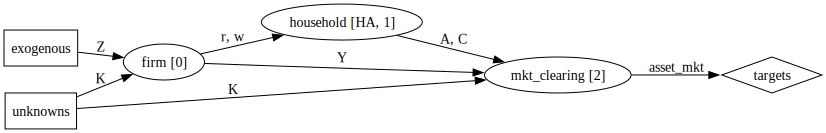

In [183]:
drawdag(ks,exogenous=inputs,unknowns=unknowns,targets=targets,leftright=True)

### 5.3 结果
这个模型中的脉冲响应是什么样的？我们方法的优美之处在于，现在我们有了$G$，我们可以几乎瞬间计算出对任何冲击的脉冲响应 -- 这只是矩阵乘法而已！

让我们首先考虑具有不同持续性的$Z$冲击，所有冲击都标准化为具有1%的初始影响，并绘制每个冲击对利率的响应。

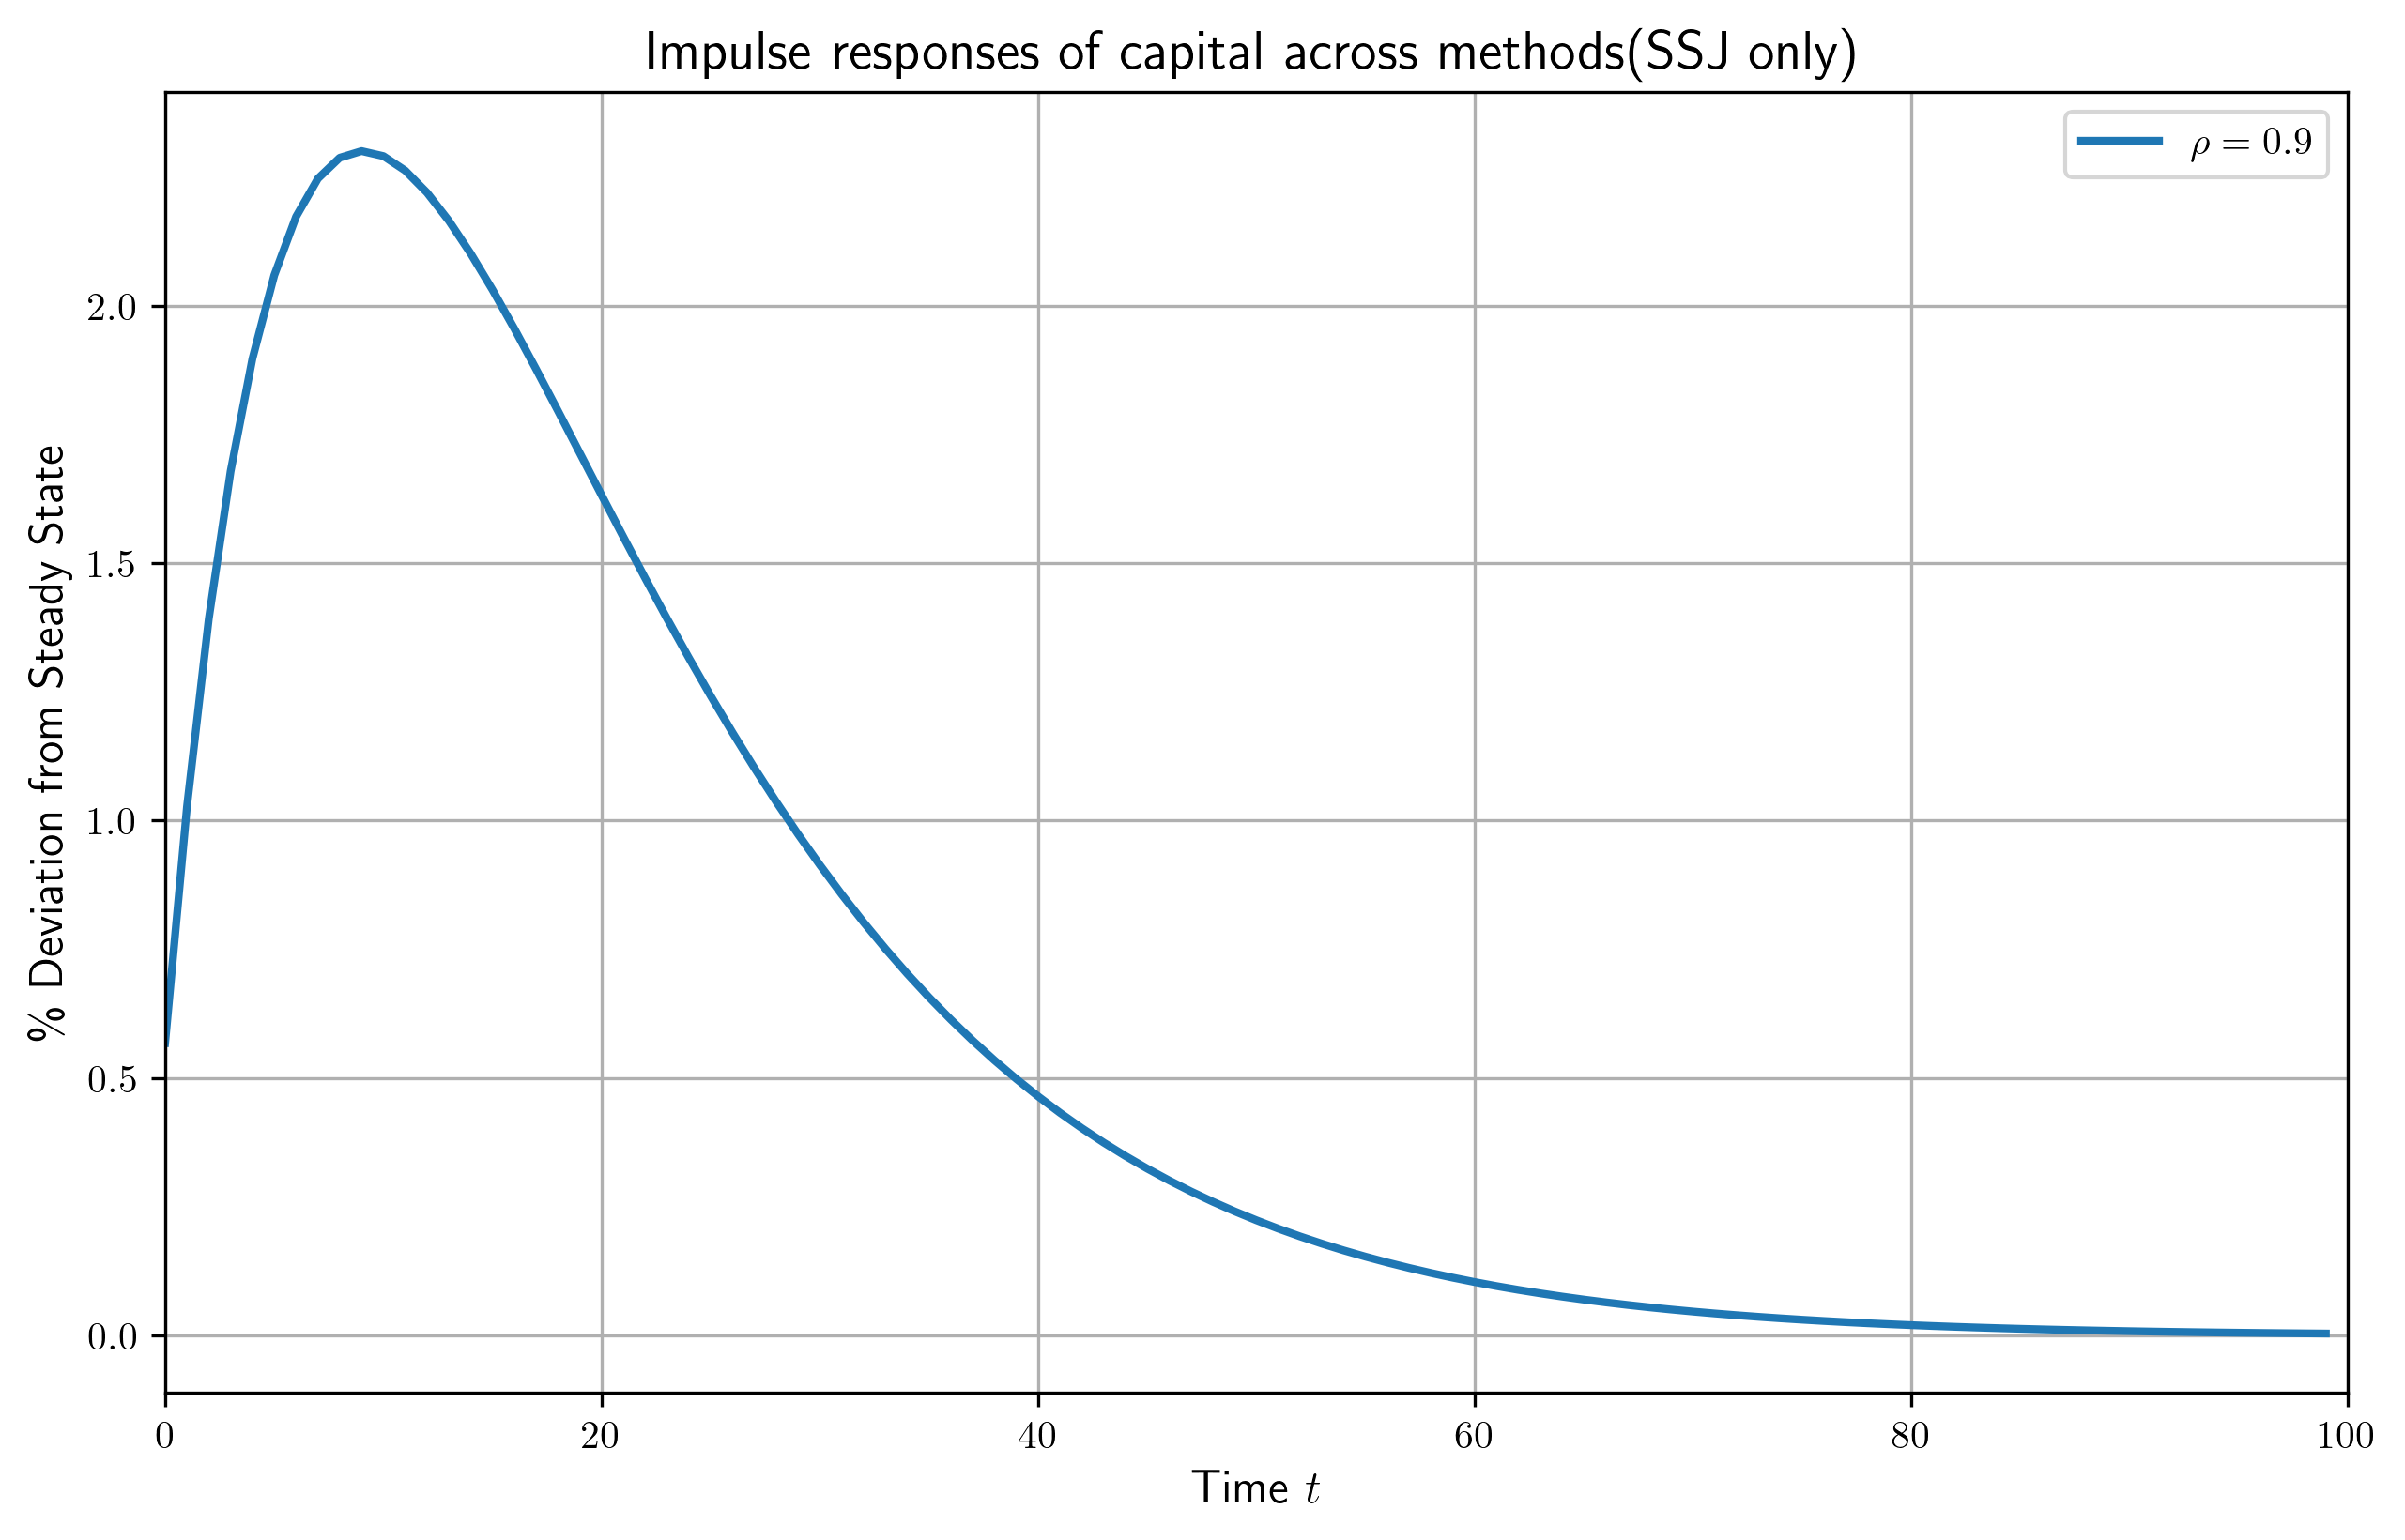

In [201]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True  # Enable LaTeX rendering for all text in plots

# Define an array of persistence parameters for the shocks to $Z$.
rhos = np.array([0.9,])

# Generate a matrix of shock paths ($dZ$) for each persistence parameter.
dZ = 0.01 * ss['Z'] * rhos ** (np.arange(T)[:, np.newaxis])

# Calculate the dynamic response of the interest rate ($r$) to the shocks in $Z$.
dr = G['r'] @ dZ
dK = G['K'] @ dZ
# Create an enhanced plot with increased figure size, resolution, markers, grid, and a legend for better clarity.
plt.figure(figsize=(10, 6), dpi=300)
for i, rho in enumerate(rhos):
    plt.plot(100 * dK[:100, i], lw=2, markersize=4, label=f'$\\rho = {rho}$')
plt.xlim(0,100)
plt.title(r'Impulse responses of capital across methods(SSJ only)', fontsize=14)
plt.ylabel(r'\% Deviation from Steady State', fontsize=12)
plt.xlabel(r'Time $t$', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Now let's consider 10,000 different values of rho, for which we can still calculate all $r$ impulse responses almost instantaneously.

In [185]:
rhos = np.linspace(0.1, 0.9, 10000)
dZ = 0.01 * ss['Z'] * rhos ** (np.arange(T)[:, np.newaxis]) # get T*5 matrix of dZ
%time dr = G['r'] @ dZ

CPU times: total: 297 ms
Wall time: 14.3 ms


这里的运行时间每次都不同，但在当前运行中(就像在个人笔记本电脑上的所有运行一样)，计算10,000个脉冲响应所需的"墙钟时间"不到20毫秒，这意味着每个脉冲响应所需时间不到**2微秒**。"CPU时间"略高，因为内置的矩阵乘法实现使用了两个核心的轻度并行化。相比之下，文献中异质性代理模型的典型脉冲响应计算至少需要一分钟，所以这种方法在计算单个脉冲响应时快了**3000万**倍以上。

虽然这可能看起来是一个极端的例子，但这种形式的重复计算在计算要求最高的应用中非常有用，比如估计(我们稍后会看到)。

我们序列空间方法的另一个重要特点是，它可以轻松计算那些难以转化为简单递归形式的冲击的响应，比如新闻冲击。

例如，计算$Z$预期在未来某个特定时期增加的新闻冲击的响应是很简单的 -- 实际上，这正是$G$矩阵的列所表示的。下面我们绘制了资本对第5、10、15、20和25期$Z$增加的新闻冲击的响应。

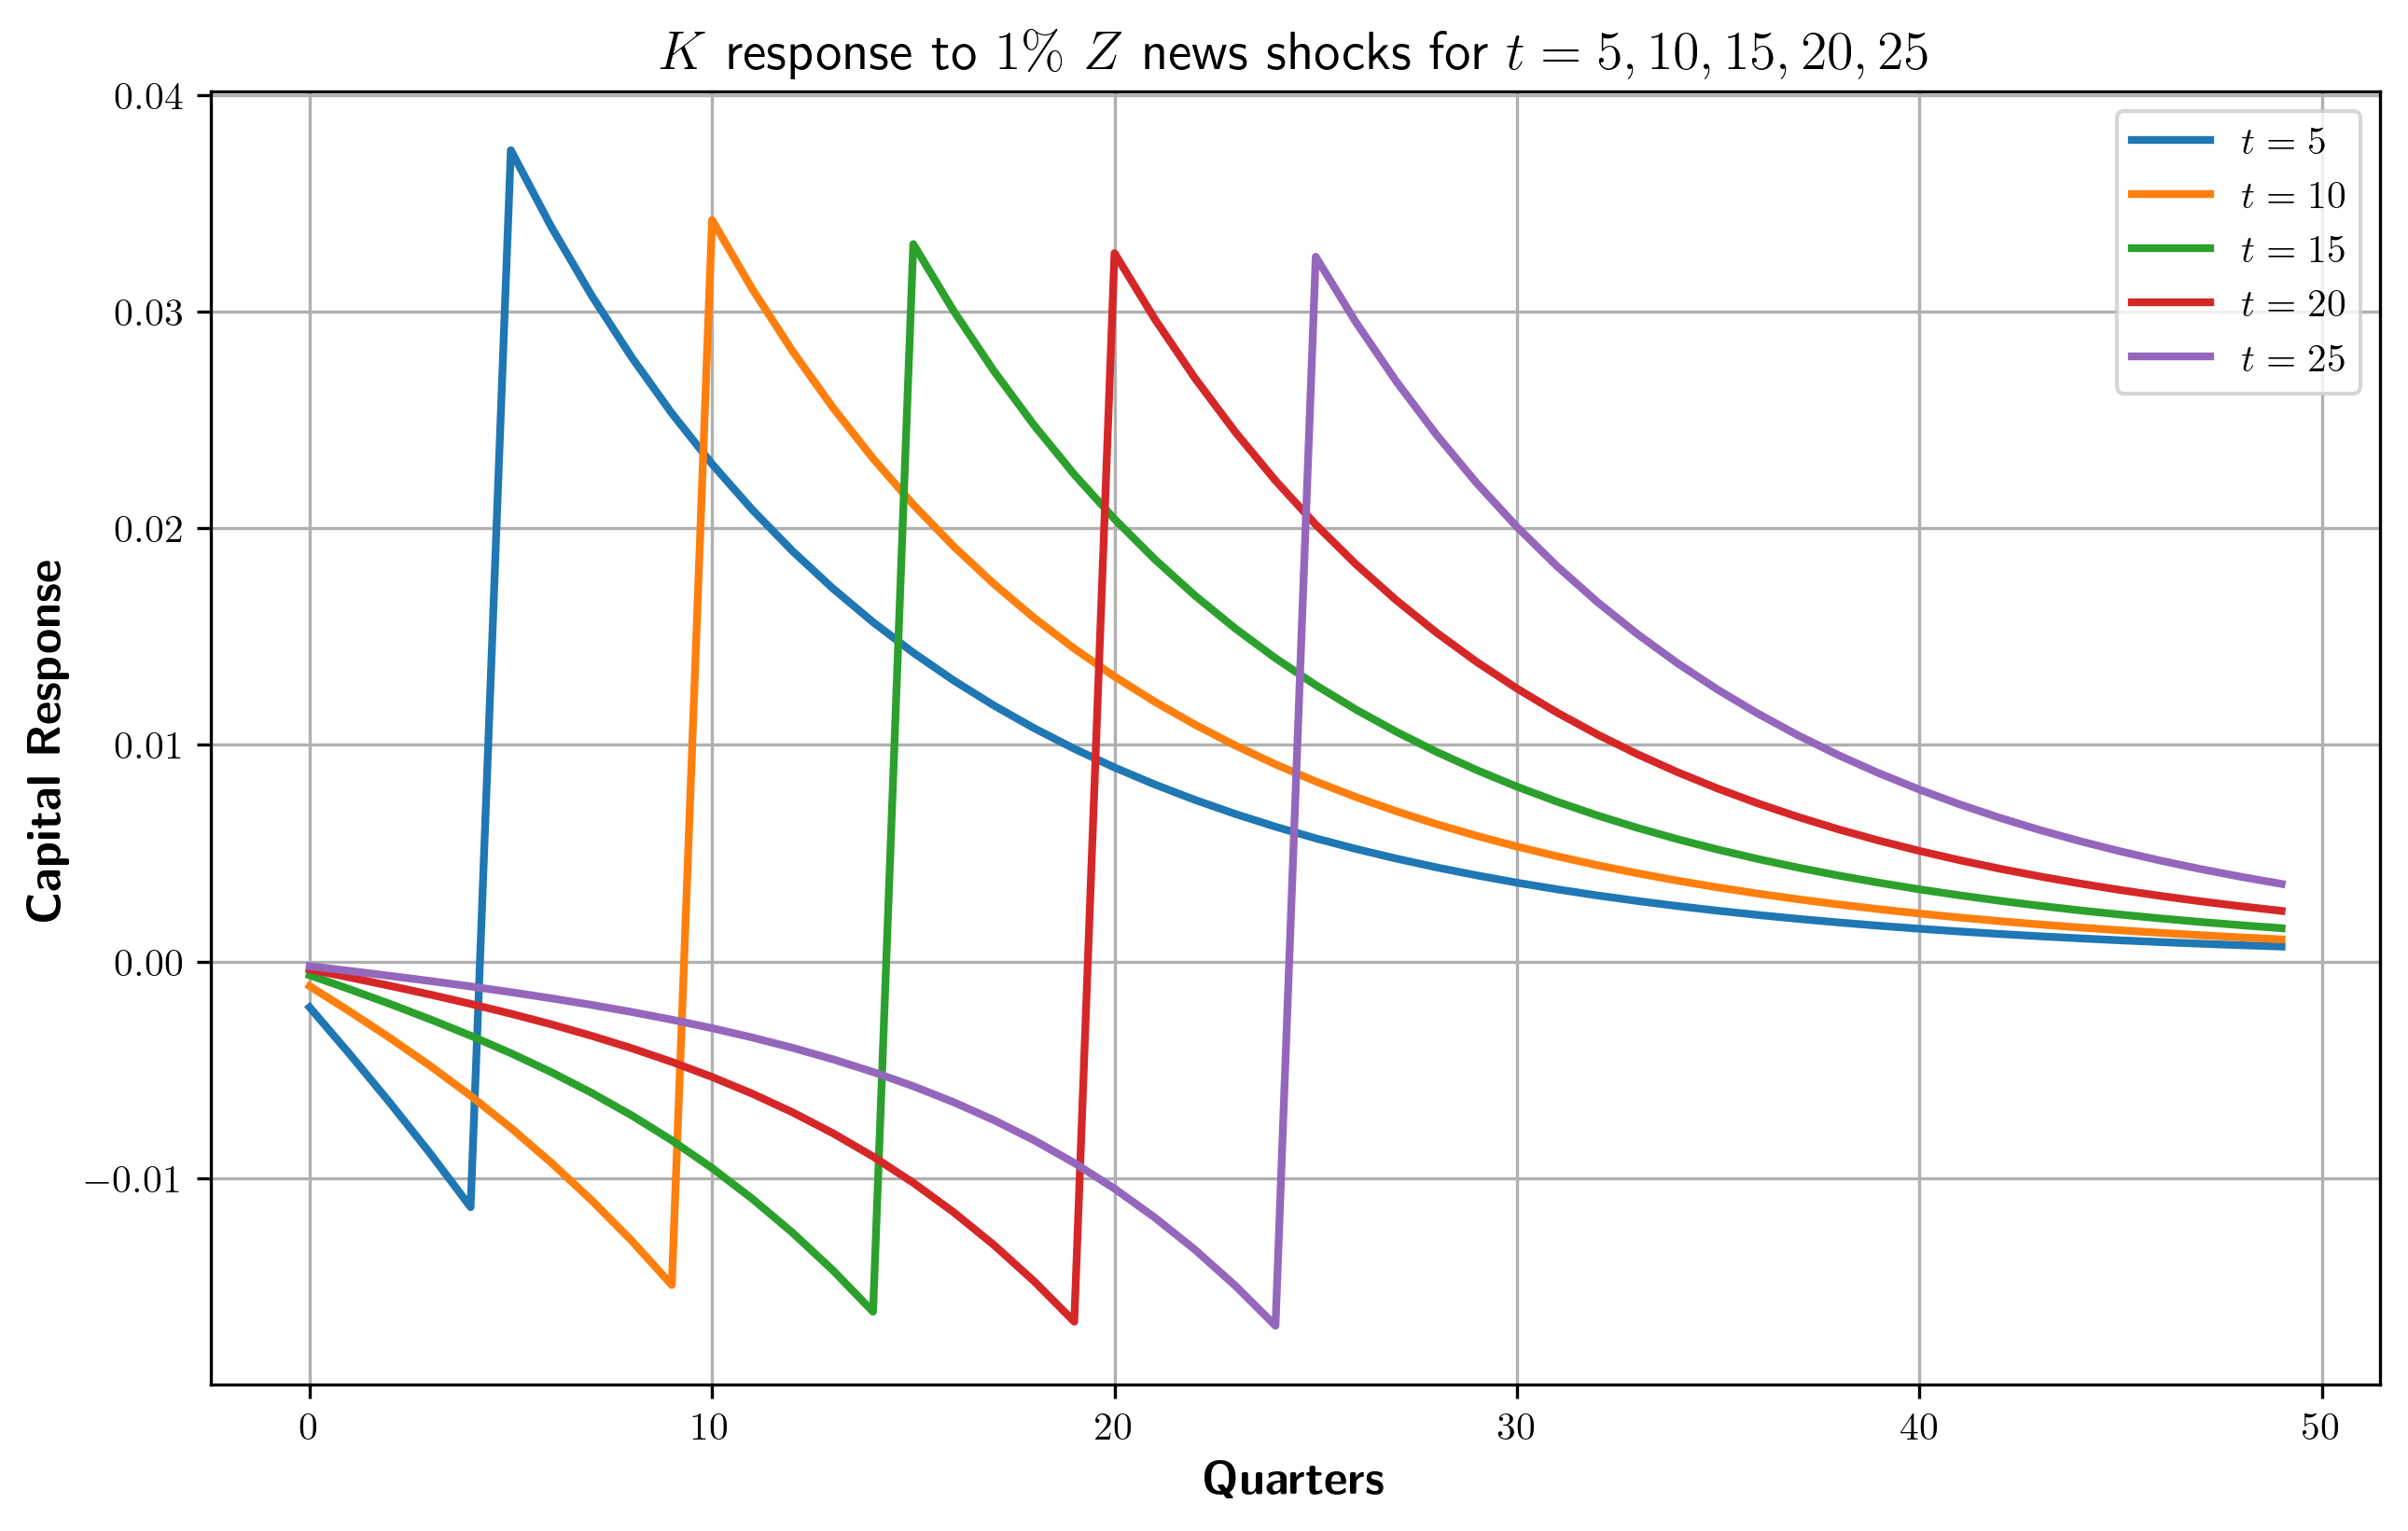

In [186]:
news_periods = np.array([5, 10, 15, 20, 25])
dZ = 0.05 * (np.arange(T)[:, np.newaxis] == news_periods)
dK = G['K'] @ dZ

plt.figure(figsize=(10, 6), dpi=300)
for i, period in enumerate(news_periods):
    plt.plot(dK[:50, i], lw=2, markersize=4, label=f'$t = {period}$')
plt.title(r'$K$ response to $1\%$ $Z$ news shocks for $t=5,10,15,20,25$', fontsize=14)
plt.xlabel(r'\textbf{Quarters}', fontsize=12)
plt.ylabel(r'\textbf{Capital Response}', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

## 6 估计

估计的路线图如下：
 - 脉冲响应 $\implies$ 二阶矩
 - 二阶矩 $\implies$ 对数似然

在本笔记本中，我们将简单地使用模拟数据来展示对数似然在估计参数(TFP冲击的标准差)的真实值附近达到峰值。

### 6.1 二阶矩
由于确定性等价，线性脉冲响应可以被解释为模型的 $MA(\infty)$ 表示。然后我们只需要冲击的二阶矩就可以完全表征内生结果的二阶矩。这种计算可以以高效的方式完成，无需任何模拟。

具体来说，让我们假设Krusell-Smith模型中的TFP冲击 $dZ$ 具有持续性和暂时性两个组成部分。

$$
\begin{align*}
dZ_t &= dZ^1_t + d Z_t^2
\\
dZ_t^1 &= \rho d Z_{t-1}^1 + \epsilon^1_t
\\
d Z_t^2 &= \epsilon^2_t
\end{align*}
$$

其中 $\epsilon^1$ 和 $\epsilon^2$ 是均值为零、方差分别为 $\sigma^2_1$ 和 $\sigma^2_2$ 的独立同分布正态随机变量。

令 $m^{x, 1}$ 和 $m^{x,2}$ 表示变量 $X$ 对这两个结构性冲击的(截断)脉冲响应。那么我们有一个 $MA(T-1)$ 表示：

$$
X_t = \sum_{z=1}^{2} \sum_{s=0}^{T-1} m^{x,z}_s \epsilon_{t-s}^z 
$$

因此，结果 $Y$ 和 $X$ 之间的协方差采用以下形式

$$
\text{Cov}(Y_t, X_{t+l})= \sum_{z=1}^{2} \sigma_z^2 \sum_{s=0}^{T-1} m_s^{x,z} m_{s+l}^{y,z} \tag{Cov}
$$

#### 步骤 1. 堆叠的脉冲响应

给定我们在第4节中计算的矩阵 $G$，这只是一个矩阵乘法的问题：

In [187]:
rho = 0.9
sigma_persist = 0.1
sigma_trans = 0.2

dZ1 = rho**(np.arange(T))
dY1, dC1, dK1 = G['Y'] @ dZ1, G['C'] @ dZ1, G['K'] @ dZ1
dX1 = np.stack([dZ1, dY1, dC1, dK1], axis=1)

dZ2 = np.arange(T) == 0
dY2, dC2, dK2 = G['Y'] @ dZ2, G['C'] @ dZ2, G['K'] @ dZ2
dX2 = np.stack([dZ2, dY2, dC2, dK2], axis=1)

让我们将这些堆叠起来，构建一个 $T\times 4 \times 2$ 数组，给出四个结果对两个冲击的所有脉冲响应：

In [188]:
dX = np.stack([dX1, dX2], axis=2)
dX.shape

(300, 4, 2)

#### 步骤 2. 计算所有超前和滞后的协方差

上述协方差公式通过快速傅里叶变换由`all_covariances`函数高效实现，该函数返回一个$T\times 4\times 4$数组`Sigma`，其中`Sigma[l, o1, o2]`给出任意时刻$t$的输出`o1`与时刻$t+l$的输出`o2`之间的协方差。

In [189]:
sigmas = np.array([sigma_persist, sigma_trans])
Sigma = estimation.all_covariances(dX, sigmas) # burn-in for jit
%time Sigma = estimation.all_covariances(dX, sigmas)

CPU times: total: 0 ns
Wall time: 0 ns


#### 可视化相关性

让我们将协方差矩阵 `Sigma` 转换为相关系数矩阵，方法是用每个序列的标准差对其进行标准化：

In [190]:
sd = np.sqrt(np.diag(Sigma[0, ...]))
correl = (Sigma/sd)/(sd[:, np.newaxis])

最后，让我们绘制从 $l=-50$ 到 $50$ 的 $\text{corr}(dZ_t,dZ_{t+l})$、$\text{corr}(dZ_t,dY_{t+l})$、$\text{corr}(dZ_t,dC_{t+l})$ 和 $\text{corr}(dZ_t,dK_{t+l})$：这些是所有序列在不同滞后期与驱动生产率过程的相关性。

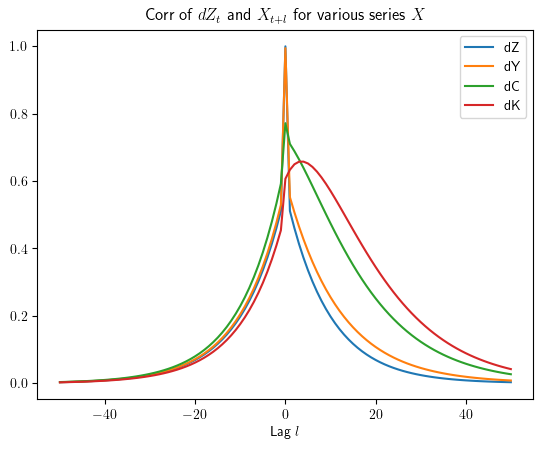

In [191]:
ls = np.arange(-50, 51)
corrs_l_positive = correl[:51, 0, :]
corrs_l_negative = correl[50:0:-1, :, 0]
corrs_combined = np.concatenate([corrs_l_negative, corrs_l_positive])

plt.plot(ls, corrs_combined[:, 0], label='dZ')
plt.plot(ls, corrs_combined[:, 1], label='dY')
plt.plot(ls, corrs_combined[:, 2], label='dC')
plt.plot(ls, corrs_combined[:, 3], label='dK')
plt.legend()
plt.title(r'Corr of $dZ_t$ and $X_{t+l}$ for various series $X$')
plt.xlabel(r'Lag $l$')
plt.show()

在这里我们可以看到解的许多特征。首先，$dY$与$dZ$极其相似，只是由于资本积累而具有更大的滞后响应。$dZ$和$dY$在$l=0$处都有一个对应于瞬态冲击的大峰值。另一方面，$dC$和$dK$都更加平滑，并且倾向于滞后于$dZ$，尤其是$dK$。

### 6.2 对数似然

假设所有序列的均值为零（这通常通过对数据进行预先的去均值化或去趋势化处理来实现），且冲击服从多元正态分布，那么我们评估对数似然只需要二阶矩和数据。

具体来说，如果我们的数据观测值堆叠在向量 $\mathbf{y}$ 中，所有滞后期的协方差堆叠在矩阵 $\mathbf{V}$ 中，那么对数似然（除去常数项）为：

$$
\mathcal{L} = -\frac{1}{2}\log(\det(\mathbf{V})) - \frac{1}{2}\mathbf{y}'\mathbf{V}^{-1}\mathbf{y} \tag{log-likelihood}
$$ 

我们的代码直接使用上一节中 `all_covariances` 返回的所有滞后期的协方差 `Sigma` 和数据序列矩阵，在底层实现了（log-likelihood）来计算对数似然。

In [192]:
# random 100 observations
Y = np.random.randn(100, 4)

# 0.05 measurement error in each variable
sigma_measurement = np.full(4, 0.05)

# calculate log-likelihood
estimation.log_likelihood(Y, Sigma, sigma_measurement)

%time estimation.log_likelihood(Y, Sigma, sigma_measurement)

CPU times: total: 0 ns
Wall time: 5.06 ms


-55197.54979275316

### 6.3 综合应用：在一个示例中计算似然
继续考虑第5.1节中的冲击过程，其中$dZ$有一个持续性分量和一个瞬态分量。假设我们不知道持续性分量的持续性参数$\rho$，也不知道这两个冲击的相对方差以及测量误差的方差。给定一些包含100个$dZ, dY, dC, dY$观测值的观测数据$\mathbf{w}$，这些参数的对数似然函数是什么样的，我们该如何计算它？

我们编写以下函数。

In [193]:
def log_likelihood_from_parameters(rho, sigma_persist, sigma_trans, sigma_measurement, Y):
    # impulse response to persistent shock
    dZ1 = rho**(np.arange(T))
    dY1, dC1, dK1 = G['Y'] @ dZ1, G['C'] @ dZ1, G['K'] @ dZ1
    dX1 = np.stack([dZ1, dY1, dC1, dK1], axis=1)
    
    # since transitory shock does not depend on any unknown parameters,
    # except scale sigma_trans, we just reuse the dX2 already calculated earlier!
    
    # stack impulse responses together to make MA(T-1) representation 'M'
    M = np.stack([dX1, dX2], axis=2)
    
    # calculate all covariances
    Sigma = estimation.all_covariances(M, np.array([sigma_persist, sigma_trans]))
    
    # calculate log=likelihood from this
    return estimation.log_likelihood(Y, Sigma, sigma_measurement)

**模拟样本数据。** 现在让我们模拟更真实的序列 $w=\{dZ, dY, dC, dK\}$，假设使用与上面相同的参数，看看对数似然的计算结果如何。

In [194]:
# stack covariances into matrix using helper function, then do a draw using NumPy routine
V = estimation.build_full_covariance_matrix(Sigma, sigma_measurement, 100)
Y = np.random.multivariate_normal(np.zeros(400), V).reshape((100, 4))

现在让我们绘制$w$的对数似然函数关于持续性分量标准差（其真实值为0.1）的图像，其中其他参数均取正确值。注意，计算100次对数似然函数耗时远低于1秒。

In [195]:
sigma_persist_values = np.linspace(0.05, 0.2, 100)
%time lls = np.array([log_likelihood_from_parameters(rho, sigma_persist, sigma_trans, sigma_measurement, Y) for sigma_persist in sigma_persist_values])

CPU times: total: 2.11 s
Wall time: 275 ms


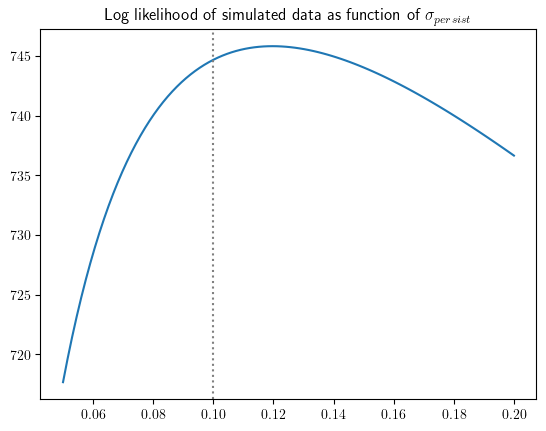

In [196]:
plt.plot(sigma_persist_values, lls)
plt.axvline(0.1, linestyle=':', color='gray')
plt.title(r'Log likelihood of simulated data as function of $\sigma_{persist}$')
plt.show()

令人欣慰的是,模式接近于用于模拟数据的参数值 $\sigma_{persist}=0.1$ (虽然由于我们只模拟了100期的有限样本,所以并不完全相等)!

## 8 非线性完全预见动态

线性化的脉冲响应在构造上对总体冲击的符号和大小是不变的。虽然这对许多应用来说不是问题，但这显然是一个局限。在这里，我们将展示雅可比矩阵在求解非线性动态时也非常有用。

考虑一个经济体从稳态开始，在0时刻收到一个意外冲击的情况。这通常被称为"MIT冲击"。

对于给定的冲击$Z$，解仍然由满足$H(K,Z)=0$的$K$来表征。我们寻找这个$K$的算法是牛顿法的一个简单变体，它对资本路径的一系列猜测$K^j$进行迭代，如下所示：
1. 从$j=0$开始，猜测一个路径$K^0$
2. 计算$H(K^j, Z)$
3. 根据以下公式更新猜测值$$K^{j+1} = K^j - H_K(K_{ss}, Z_{ss})^{-1} H(K^j, Z)$$
然后返回步骤2进行$j+1$次迭代

这与标准牛顿法的唯一区别是我们使用稳态附近的雅可比矩阵$H_K$（我们已经计算过），而不是当前猜测值附近的雅可比矩阵（这在计算上更加困难）。尽管如此，这种方法通常能实现极快的收敛。

虽然用迭代方法求解对MIT冲击的均衡响应在异质性代理文献中很常见，但这些方法通常使用特定的规则来更新猜测值，这可能既脆弱又缓慢。在没有或仅有有限异质性（如消费者-储蓄者模型）的应用中，如果可以轻松计算雅可比矩阵，牛顿法已被用来提供更快和更稳健的收敛 -- 参见例如[Juillard (1996)](http://www.cepremap.fr/depot/couv_orange/co9602.pdf)。

但直到现在，这还没有被应用到异质性代理模型中，因为雅可比矩阵太难计算。据我们所知，目前仅有的部分应用是在[Auclert and Rognlie (2018)](http://web.stanford.edu/~aauclert/computational_appendix_inequad.pdf)中，他们使用辅助模型来计算近似雅可比矩阵，以及在[Straub (2018)](https://scholar.harvard.edu/files/straub/files/jmp_straub_jan_2.pdf)中，他们使用插值来计算近似雅可比矩阵。然而，在本文中，我们提供了一种高效的方法来计算任何异质性代理模型在稳态附近的精确雅可比矩阵，因此可以直接应用牛顿法。

### 8.1 实现

我们的拟牛顿法可以分两步实现。首先，构建非线性函数$H(U, Z)$。其次，对给定的$Z$猜测$U$并迭代直至收敛。我们已经将这两个步骤自动化，所以我们只需要为`ks`对象调用`solve_impulse_nonlinear`方法。我们还将使用`solve_impulse_linear`方法求解线性化动态以进行比较。

注意，冲击和结果（在`ImpulseDict`对象中）都表示为相对于稳态的偏差。

In [197]:
Z_shock_path = {"Z": 0.01*0.8**np.arange(T)}

td_nonlin = ks.solve_impulse_nonlinear(ss, unknowns, targets, Z_shock_path)
td_lin = ks.solve_impulse_linear(ss, unknowns, targets, Z_shock_path)

print(td_nonlin)

Solving Krusell-Smith for ['K'] to hit ['asset_mkt']
On iteration 0
   max error for asset_mkt is 3.43E-02
On iteration 1
   max error for asset_mkt is 7.55E-05
On iteration 2
   max error for asset_mkt is 1.57E-07
On iteration 3
   max error for asset_mkt is 1.94E-10
<ImpulseDict: ['Z', 'K', 'A', 'C', 'r', 'w', 'Y', 'asset_mkt', 'goods_mkt'], internals=['household']>


我们可以看到这个方法非常快,在初始猜测之后仅需3次迭代就达到了高精度 -- 远少于典型的特定更新规则所需的数百甚至数千次迭代。

现在让我们将其与线性化的脉冲响应结果进行比较,并绘制实际利率$r$的路径。

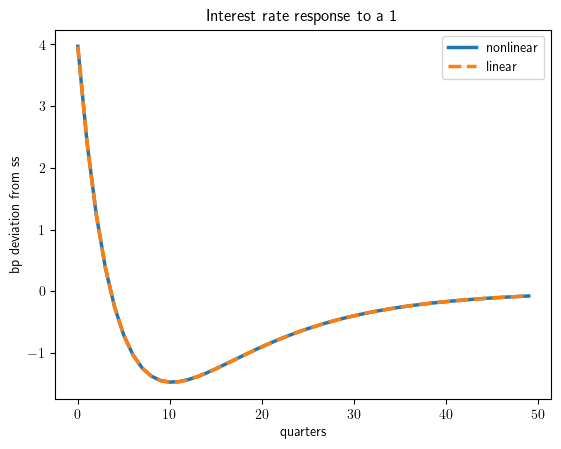

In [198]:
dr_nonlin = 10000 * td_nonlin['r']
dr_lin = 10000 * td_lin['r']

plt.plot(dr_nonlin[:50], label='nonlinear', linewidth=2.5)
plt.plot(dr_lin[:50], label='linear', linestyle='--', linewidth=2.5)
plt.title(r'Interest rate response to a 1% TFP shock')
plt.ylabel(r'bp deviation from ss')
plt.xlabel(r'quarters')
plt.legend()
plt.show()

这里没有明显的差异 -- 一阶近似在这种情况下几乎是完美的。

如果我们将生产率冲击的初始幅度增加到10%（这是一个巨大的冲击！），我们就可以开始看到一些非线性效应出现，而且求解需要五次迭代而不是三次：

Solving Krusell-Smith for ['K'] to hit ['asset_mkt']
On iteration 0
   max error for asset_mkt is 3.55E-01
On iteration 1
   max error for asset_mkt is 6.32E-03
On iteration 2
   max error for asset_mkt is 1.38E-04
On iteration 3
   max error for asset_mkt is 1.86E-06
On iteration 4
   max error for asset_mkt is 1.81E-08
On iteration 5
   max error for asset_mkt is 4.25E-10


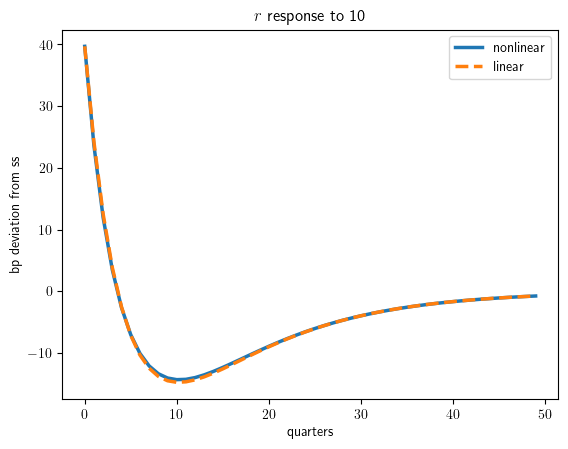

In [199]:
big_Z_shock_path = {"Z": 0.1*0.8**np.arange(T)}

td_nonlin = ks.solve_impulse_nonlinear(ss, unknowns, targets, big_Z_shock_path)
td_lin = ks.solve_impulse_linear(ss, unknowns, targets, big_Z_shock_path)

# extract interest rate response, scale to basis points
dr_nonlin = 10000 * td_nonlin['r']
dr_lin = 10000 * td_lin['r']

plt.plot(dr_nonlin[:50], label='nonlinear', linewidth=2.5)
plt.plot(dr_lin[:50], label='linear', linestyle='--', linewidth=2.5)
plt.title(r'$r$ response to 10% $Z$ shock')
plt.ylabel(r'bp deviation from ss')
plt.xlabel(r'quarters')
plt.legend()
plt.show()